# Problems

The data has no clear driver-nodes necessarily. It is currently impossible to determine the driver-nodes a priori in kinetic Ising models. Some graphs would have a clear driver-node, i.e 1 node that is significantly higher than any other node in the system. Howevever, sometimes some nodes may overlap. In terms of mutual information this could be due to bias. 


Possible solutions involve obtaining the correct set either statistically or through some other metric. 
- A statistical test that is able to account for noise and identifies the correct set.
- A clustering algorithm that obtains clusters for the data


In [1]:
%%javascript
require("notebook/js/notebook").Notebook.prototype.scroll_to_bottom = function () {}

<IPython.core.display.Javascript object>

In [2]:
import numpy as np, sys, os, holoviews as hv, scipy
sys.path.insert(0, '../') # add normal modules
from Utils import IO, plotting as plotz
import matplotlib.pyplot as plt
from matplotlib import style
from tqdm import tqdm_notebook as tqdm
style.use('seaborn-notebook')
%load_ext autoreload
%autoreload 2

AttributeError: 'str' object has no attribute 'insert'

In [121]:
# root = '../Data/new36/2019-08-26T16:33:44.688796' #2019-07-28T12:06:25.665575'
root = '../Data/new40/2019-09-14T07:29:05.716206'
# root = '/mnt/test/new38/2019-09-05T12:31:44.644750'
# root = '/mnt/test/new35'
from Utils import IO
# data = IO.DataLoader(root)

# data = {os.path.join(root, k): v for k,v in tqdm(data.items())}

# settings = {k: IO.Settings(os.path.join(root, k)) for k in data}

import multiprocessing as mp
from multiprocessing.pool import ThreadPool
processes = mp.cpu_count()

# aucs = loadedData = {}
# settings = IO.loadSets(data)

In [122]:
settings = {}
print(root)
# load settings
for (r, dirs, files) in os.walk(root):
    for file in files:
        if 'settings' in file:
            path = os.path.join(r, file)
            settings[r] = IO.loadPickle(path)
#         if file.endswith('.pickle'):
#             data.append(os.path.join(root, file))
import re

# setup matrices
data = {}
for k, v in settings.items():
    eq = v.get('equilibrium')
    nTemps = len(eq.get('ratios'))
    nTrials = v.get('nTrials') + 1
    nPulse = v.get('graph').number_of_nodes() + 1
    deltas = v.get('deltas')
    
    s =  (nTrials, nPulse, nTemps, deltas) 
    data[k] = np.zeros(s)
    

../Data/new40/2019-09-14T07:29:05.716206


In [ ]:
c = 0
cc = 0
from tqdm import tqdm_notebook as tqdm
for k, v in data.items():
    path = os.path.join(k, 'data')
    for file in tqdm(os.listdir(path)):
        # load file
        tmp = IO.loadPickle(os.path.join(path, file))
        cc += 1
#         find correct index
        if not isinstance(tmp, dict):
            print('found')
            
        else:
            c += 1

found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found



In [ ]:
print(c/cc)

In [5]:
# tmp = dict(settings = settings, aucs = aucs)
# IO.savePickle('THIS', dict(tmp))
tmp = IO.loadPickle('THIS.pickle')
print(tmp.keys())
for k, v in tmp.items():
    print(k, len(v))
    globals()[k] = v
    
    
# for k, v in aucs.items():
#     print(k in settings)
#     assert k in settings.keys()

dict_keys(['settings', 'aucs'])
settings 30
aucs 29


In [5]:
# root = '../Data/new32/'
# data = IO.DataLoader(root)
# data = {os.path.join(root, k): v for k,v in tqdm(data.items())}

# for k, v in IO.loadSets(data).items():
#     settings[k] = v

IndexError: index 1 is out of bounds for axis 1 with size 1

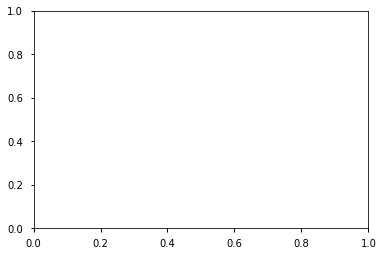

In [6]:
tmp = [i.data for idx, i in enumerate(settings.values()) if idx < 2]

fig, ax = plt.subplots()
ax.plot(np.nanmean(tmp[0][0,1], 0).T)
fig.show()



print(np.asarray(tmp).shape)
print(tmp[0][1,1])

In [31]:
import multiprocessing as mp
def worker(sample):
    # tmp workaround
    if len(sample.shape) == 1:
        sample = sample.reshape(-1, 1)
    auc = np.zeros((len(sample), 2))
    x = np.arange(sample.shape[-1])
    
    tmp = np.arange(x.max() * 100, x.max() * 150, 3)
    
    
    x = np.concatenate((x, tmp))
    padded = np.zeros(tmp.size)
    
    sample = np.array([\
                       np.concatenate((i, padded)) for i in sample\
                      ])
    coeffs, errors = plotz.fit(sample, func, x = x, params = fitParam)
    for nodei, c in enumerate(coeffs):
        tmp = 0
        F      = lambda x: func(x, *c)
        tmp, _ = scipy.integrate.quad(F, 0, LIMIT)
        auc[nodei, 0] = tmp
        auc[nodei, 1] = errors[nodei]
        if errors[nodei] > .1:
            print('error large')
    auc[auc < np.finfo(auc.dtype).eps ] = 0
    return auc[:, 0]
from tqdm import tqdm

double = lambda x, b, c, d, e, f, g: b * np.exp(-c*(x - g)) + d * np.exp(- e * (x-f))

double_= lambda x, b, c, d, e, f, g:b * np.exp(-c*(x - g)) + d * np.exp(- e * (x - f ))
single = lambda x, a, b, c : a + b * np.exp(-c * x)
single_= lambda x, a, b, c : a + b * np.exp(-c * x)
special= lambda x, a, b, c, d: a  + b * np.exp(- (x)**c - d)

func        = double
p0          = np.ones((func.__code__.co_argcount - 1)); # p0[0] = 0
fitParam    = dict(\
                   maxfev = int(1e6), \
                   bounds = (0, np.inf), p0 = p0,\
                   jac = 'cs', \
                  )
aucs = {}
for k, setting in tqdm(settings.items()):
    LIMIT = setting.deltas // 2 - 1
    LIMIT = np.inf
    s = setting.data.shape
    
    v = setting.data.reshape(-1, *s[-2:])
    
    with mp.Pool(mp.cpu_count()) as p:
        auc = np.asarray(p.map(worker, v)).reshape(s[:-1])
    aucs[k] = auc

100%|██████████| 10/10 [25:12<00:00, 154.81s/it]


In [ ]:
a = np.random.rand(10, 3)
print(a.order)

In [32]:
%load_ext autoreload
%autoreload 2
from Utils.stats import determineDrivers
# aucs = {k: aucs[k] for k, v in settings.items() if k in }
tmp     = np.array([i[...,  :] for i in aucs.values()])
tmp     = np.argsort(tmp, axis = -1)[..., -1]
mi      = tmp[:, 0]
pulses  = tmp[:, 1:]


print(mi.shape, pulses.shape)

nData, nPulse, nTemp, nTrials = pulses.shape

d = np.zeros((nData, nPulse, nTemp))
s = d.shape

alpha = .10
print(pulses.shape)


f = np.zeros((nData, nPulse, nTemp), dtype = set)
for dataidx in range(nData):
    for temp in range(nTemp):
        y = mi[dataidx, temp]
        p, mi_driver = determineDrivers(y, alpha)
        mid = set(i[0] for i in mi_driver)
        for pulse in range(nPulse):
            x = pulses[dataidx, pulse, temp]
            pp, p_driver = determineDrivers(x, alpha)
            
            pid = set(i[0] for i in p_driver)
            
            e =  len(pid.intersection(mid))  / len(mid.union(pid))
            
            f[dataidx, pulse, temp] = [mid, pid]
#             print(dataidx, pid, mid)
            d[dataidx, pulse, temp] = e
# print(d.shape)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
(10, 1, 50) (10, 9, 1, 50)
(10, 9, 1, 50)


<IPython.core.display.Javascript object>


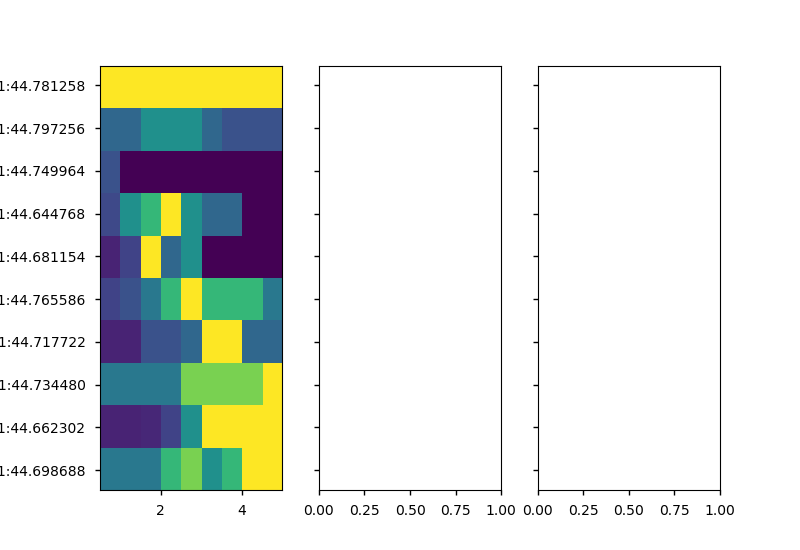

IndexError: index 1 is out of bounds for axis 2 with size 1

In [33]:
%matplotlib notebook
fig, ax = plt.subplots(1, 3, sharey = 'all')
for idx, axi in enumerate(ax):
    
    l = list(settings.keys())
    l = [i.split('/')[-1] for i in l][::-1]
    yt = np.linspace(0, len(l), len(l)) + .5
    h = axi.imshow(d[..., idx], aspect = 'auto', extent = [0.5, 5, 0, len(l) + 1])
    axi.set_yticks(yt)
    axi.set_yticklabels(l)
    aucs[k]
mainax = fig.add_subplot(111, frameon = 0, xticks = [], yticks = [])
mainax.set_ylabel('Data idx', labelpad = 40)
mainax.set_xlabel('Intervention size', labelpad = 20)
fig.colorbar(h, ax = axi)
fig.subplots_adjust(wspace = .05)

print(d.shape)
avg = d.max(1).mean()
mainax.set_title(f"Driver-node procedure accuracy\nmax avg={avg:.2f}")
fig.show()

# Clustering

Trying dbscan method


In [ ]:
from sklearn.cluster import DBSCAN, MeanShift
tmp = np.array([i[...,:] for i in aucs.values()])
m = MeanShift()
ndata, npulse, ntemp, ntrials, nnodes = tmp.shape

y = np.zeros((ndata, npulse, ntemp), dtype = set)
yy= np.zeros(y.shape)
for i in range(ndata):
    for j in range(npulse):
        for k in range(ntemp):
            c = m.fit(tmp[i, j, k].T)
            idx = c.cluster_centers_.mean(1).argmax()
            driver = set([jdx for jdx, i in enumerate(c.labels_) if i == idx])
            y[i, j, k] = driver
            mi_driver = y[i, 0, k]
            
#             print(mi_driver, driver)
            yy[i, j, k] = len(driver.intersection(mi_driver)) / (len(driver.union(mi_driver)))
            
            

In [ ]:
print(yy.shape)

fig, ax = plt.subplots(1, 3, sharex = 'all', sharey = 'all')
l = '0.8 0.7 0.6'.split()
for i in range(3):
    tax = ax[i]
    tax.imshow(yy[:, 1:, i], aspect = 'auto', vmin = 0, vmax = 1)
    tax.set_title(l[i])
mainax = fig.add_subplot(111, frameon = 0, xticks = [], yticks = [])
mainax.set_title(f'{yy[:, 1:].max(1).mean()}\n\n')
xlabel = 'Intervention size'
ylabel = 'Data idx'

mainax.set_xlabel(xlabel, labelpad = 20)
mainax.set_ylabel(ylabel, labelpad = 30)
fig.show()

# P-value confidence interval method


In [34]:
from statsmodels.stats.proportion import proportion_confint

def pci(ranks, alpha = .05):
    """
    Compute confidence interval on binomial successes
    with willson correction
    """
    from collections import Counter
    hist = Counter(ranks)
    
#     pvals = {}
    from scipy.stats import norm, multinomial, chi2_contingency
#     z = norm.ppf(1 - alpha / 2)
#     n = len(hist)
    n = len(ranks)
    
    hist = dict(sorted(hist.items(), key = lambda x : x[1])[::-1])
    
    candidates = [i for i in hist.keys()]
    success = [i for i in hist.values()]
    
#     print(success)
    for ni in range(len(hist)):
        p = multinomial.pmf(success[:ni + 1], n = n, p = np.ones(ni + 1) * 1/(ni + 1))
#         chi2, p, dof, expected = chi2_contingency(t,  correction = 0)
#         print(chi2, p, dof, expected)
        driverset = set(candidates[:ni + 1])
        if p >= alpha:
#             print(driverset, hist)
            break
    
    return driverset      


def pci2(ranks, alpha = .05):
    from collections import Counter
    from statsmodels.stats.proportion import multinomial_proportions_confint as mpci
    
    hist = Counter(ranks)
    hist = dict(sorted(hist.items(), key = lambda x : x[1])[::-1])
    candidates = list(hist.keys())
#     print(candidates, hist)
    if len(candidates) > 1:
        intervals = mpci(list(hist.values()), alpha = alpha)
        driverSet = set([candidates[0]])
        for idx, (lower, upper) in enumerate(intervals[1:]):
            if upper >= intervals[0, 0]:
                driverSet.add(candidates[idx + 1])
        return driverSet
    else:
        return set(candidates)
    
        
    

In [44]:

tmp = np.array([i[..., :, :] for i in aucs.values()])
tmp = tmp.argmax(-1)
print(tmp.shape)
ndata, npulse, ntemp, ntrials = tmp.shape

y = np.zeros((ndata, npulse, ntemp), dtype = set)
yy = np.zeros((ndata, npulse, ntemp))
yyy = np.zeros((ndata, npulse, ntemp), dtype = float)
alpha = 0.05
for i in range(ndata):
    for j in range(npulse):
        for k in range(ntemp):
            ranks = tmp[i, j, k]
            drivers = pci2(ranks, alpha)
            y[i, j, k] = drivers
            mi_drivers = y[i, 0, k]
            yy[i,j,k] = len(\
                            drivers.intersection(mi_drivers)) / len(mi_drivers.union(drivers))
            
            yyy[i, j, k] = len(y[i, j, k])

(10, 10, 1, 50)


In [ ]:
for k, v in aucs.items():
    print(v)

<IPython.core.display.Javascript object>


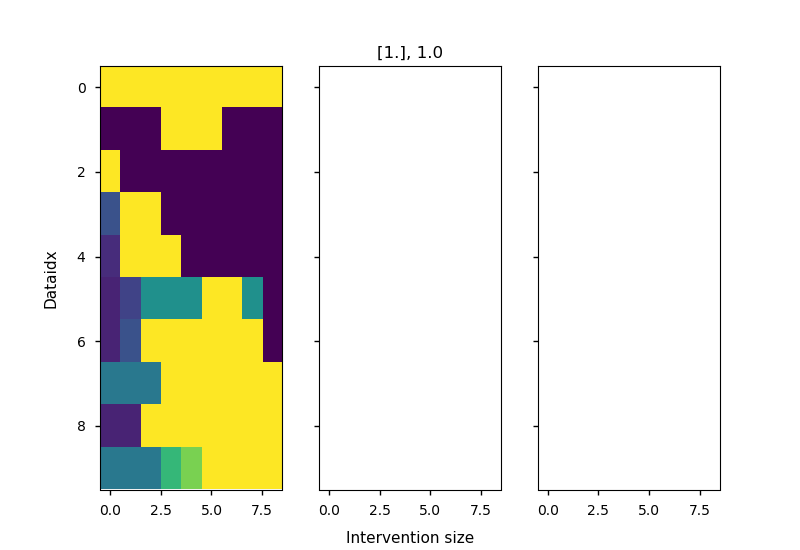

(10, 10, 1)
(10, 10, 1)
(10, 10, 1)


<IPython.core.display.Javascript object>


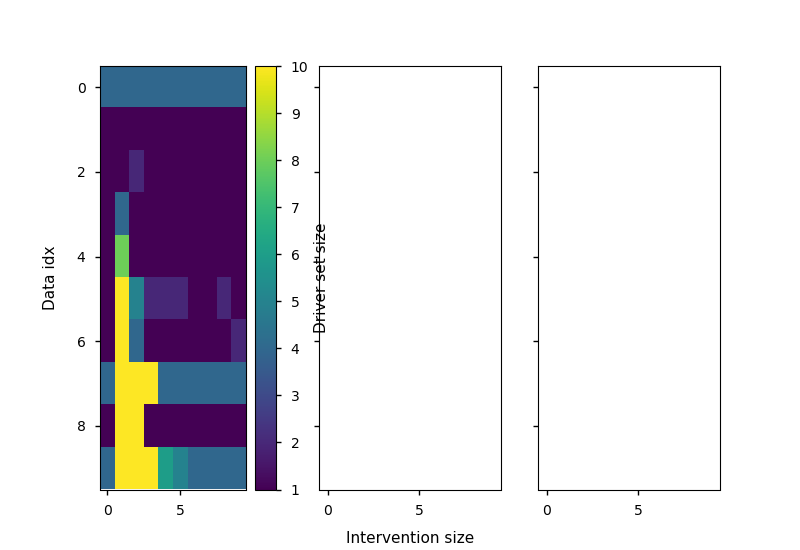

In [45]:
gs = dict(width_ratios = [1, 1, 1, .1],
#          height_ratios = [1]
         )
# for idx, k in enumerate(aucs):
#     print(idx, k, y[idx])
gs = {}
fig, ax = plt.subplots(1,3 , sharex = 'all', sharey = 'all', gridspec_kw = gs)
# print([][1:])
print(yy.shape)
for i in range(yy.shape[-1]):
    tax = ax[i]
    h = tax.imshow(yy[:, 1:, i], aspect = 'auto', vmin = 0, vmax = 1)
mainax = fig.add_subplot(111, frameon = 0, xticks = [], yticks = [])
mainax.set_title(f'{yy[:, 1:].max(1).mean(0)}, {yy[:, 1:].max(1).mean()}')

mainax.set_xlabel('Intervention size', labelpad = 30)
mainax.set_ylabel('Dataidx', labelpad = 30)

# tax = ax[-1]
# fig.colorbar(h, ax = tax)
# tax.axis('off')
fig.show()

print(y.shape)
print(yyy.shape)
fig, ax = plt.subplots(1, 3, sharex = 'all', sharey  = 'all')
for i in range(yyy.shape[-1]):
    tax = ax[i]
    h = tax.imshow(yyy[..., i], aspect = 'auto')
fig.colorbar(h, ax = tax, label = 'Driver set size')
mainax = fig.add_subplot(111, frameon = 0, xticks = (), yticks = ())
mainax.set_xlabel('Intervention size', labelpad = 30)
mainax.set_ylabel('Data idx', labelpad = 30)
fig.show()

# print(y)


# Sensitivity tests

How much does the proposed algorithm actually identify the correct values? For sensitivity, random choice is assumed for $D$ drivers nodes where $D \in \{ 1, \dots, N \}$. Using a random choice, $n = 10$ random samples are drawn from $D$ driver-nodes. The process is repeated for $N = 10 000$ repeats. 

<IPython.core.display.Javascript object>


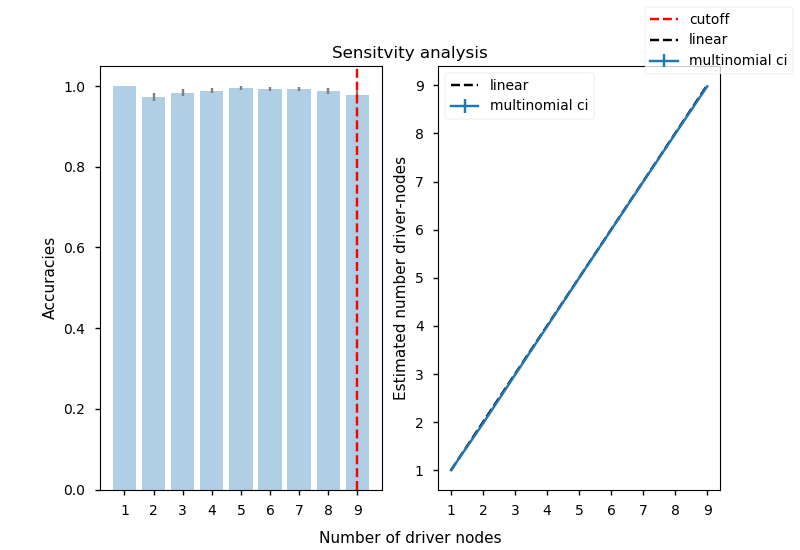

/home/casper/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.


In [48]:
def sensitivity(nDrivers = 10, 
                nTrials = 10, 
                repeats  = 100, 
                alpha = .05, \
                func = pci):
    """
    How many drivers nodes can be identified in :nTrials:
    """
    import multiprocessing as mp
    from collections import Counter
    from functools import partial
    
    tmp = partial(func, alpha = alpha)
    
    accuracies = np.zeros((nDrivers - 1, repeats))
    for nDriver in range(1, nDrivers):
        ranks = np.random.choice(nDriver, size = (repeats, nTrials))
        with mp.Pool(mp.cpu_count()) as p:
            for idx, driverSet in enumerate(p.map(tmp, ranks)):
#                 print(nDriver, driverSet)
#                 print(nDriver, driverSet, pval, Counter(ranks[idx]))
                accuracies[nDriver - 1, idx] = len(driverSet)
    return accuracies

params = dict(
            nDrivers = 10,\
            nTrials = 50,\
            repeats = 1000,\
            alpha = alpha)
# accuracies = sensitivity(**params, func = pci)
accuracies2= sensitivity(**params, func = pci2)
xr = np.arange(len(accuracies2)) + 1
from scipy.stats import sem
# plot the accuracies
fig, (ax1, ax2) = plt.subplots(1, 2)
# y1 = np.asarray([i == j for i, j in zip(accuracies, np.arange(1, len(accuracies) + 1))])
y2 = np.asarray([i == j for i, j in zip(accuracies2, np.arange(1, len(accuracies2) + 1))])
# ax1.errorbar(xr, y1.mean(1), 2 * sem(y1, axis = 1), linestyle = 'none', color = 'k')

ax1.errorbar(xr, y2.mean(1), 2 * sem(y2, axis = 1), linestyle = 'none', color = 'gray')


theta = np.argwhere(y2.mean(1).round(2) < 1 - alpha)
theta = theta[0] if theta else xr[-1]

ax1.axvline(theta, linestyle = 'dashed', color = 'red', label = 'cutoff')
ax1.set(ylabel = 'Accuracies')
# ax1.bar(xr, y1.mean(1), alpha = .35)
ax1.bar(xr, y2.mean(1), alpha = .35)
ax1.set_xticks(xr)

labels = 'multinomial\tmultinomial ci'.split('\t')
# plot the size of the sets
# ax2.errorbar(xr, accuracies.mean(1), 2 * sem(accuracies, axis = 1), label = labels[0])
ax2.errorbar(xr, accuracies2.mean(1), 2 * sem(accuracies2, axis = 1), label = labels[1])
ax2.plot(xr, xr, '--k', label = 'linear')
ax2.set(ylabel = 'Estimated number driver-nodes')
ax2.set_xticks(xr)
ax2.legend()

mainax = fig.add_subplot(111, frameon = 0, xticks = [], yticks = [])
mainax.set_title('Sensitvity analysis')
mainax.set_xlabel('Number of driver nodes', labelpad = 30)

fig.legend()
fig.show()

0.05
0.0 0
[1.]


<IPython.core.display.Javascript object>


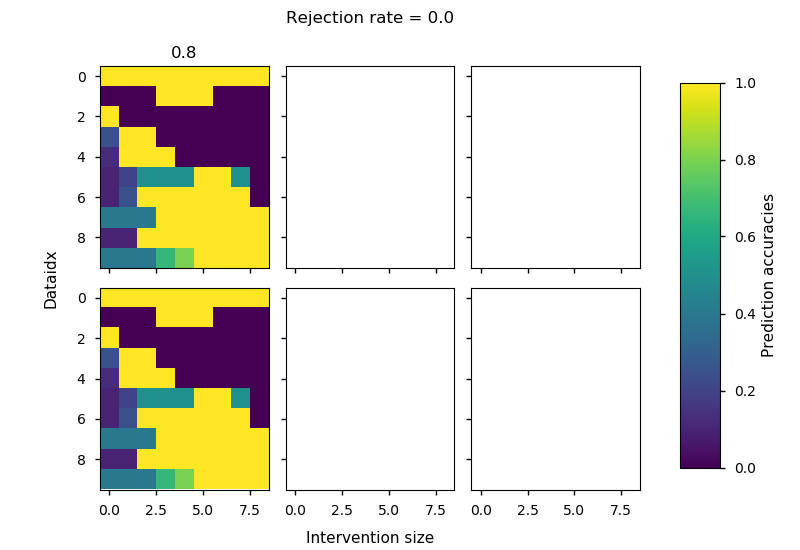

In [51]:
# filter the data based on sensitivity result
print(alpha)


tmp = yy[:, 1:].argmax(1)

dataidx, ntemp =  tmp.shape
clusterSizes = np.zeros((dataidx, ntemp), dtype = float)
dd = yy.copy()

counter = 0
total = 0
for i in range(dataidx):
    for j in range(ntemp):
        if yyy[i, tmp[i, j] + 1, j] > theta:
            dd[i, :, j] = np.NaN
            counter += 1
        total += 1
print(counter / (len(dd) * 3), counter)


print(np.nanmean(np.nanmax(dd[..., 1:, :], axis = 1),0 ))
fig, ax = plt.subplots(2, 3, sharex = 'all', sharey = 'all')


cmap = plt.cm.viridis
cmap.set_bad('black',1.)

l = '0.8 0.7 0.6'.split()
for i in range(dd.shape[-1]):
    tax = ax[0, i]
#     tax.imshow(yy[..., 1:, i], aspect = 'auto', zorder = 5)
    tax.imshow(dd[..., 1:,  i], aspect = 'auto', cmap = cmap
              )
    tax.set_title(l[i])
    
    tax = ax[1, i]
    h = tax.imshow(yy[..., 1:, i], aspect = 'auto')
mainax = fig.add_subplot(111, frameon = 0, xticks = (), yticks = ())
mainax.set_xlabel('Intervention size', labelpad = 30)
mainax.set_ylabel('Dataidx', labelpad = 30)
mainax.set_title(f'Rejection rate = {counter / total}\n\n')

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(h, cax=cbar_ax, label = "Prediction accuracies")
# fig.colorbar(h, ax = ax.flat)
fig.subplots_adjust(wspace = .1, hspace = .1)

87 34 87


In [ ]:
tmp = np.array([i[..., :10, :] for i in aucs.values()])
print(tmp.shape)
d = tmp[2, 3, 0].argmax(-1)
print(d)
pci(d, .01)

from statsmodels.stats.proportion import multinomial_proportions_confint

print(d.shape)

from collections import Counter
hi = dict(sorted(Counter(d).items(), key = lambda x: x[1])[::-1])
ci = multinomial_proportions_confint(list(hi.values()), .01)
print(ci.shape, ci)

We see a sharp drop-off for $D \geq 2$ driver-nodes. The algorithm tends to underestimate the number of driver-nodes (conservative test). 

# Isomorphism

Prediction accuracy could be affected by isomorphism; the current approach however will catch away those cases as the we expect the nodes to be very similar. However, there are some graphs above that do not provide a perfect score, why?

A non-perfect score indicates a problem. The problem could be however due to different origins. 

- Bias affecting MI scores
Due to bias it is possible that the proposed approach falsely identifies a driver-node. 

- Noise difference
slight differences in the decays may yield a smaller set or larger set than is identified by the other approach

Can we test for isomorphism if it is not compatible?


In [ ]:
# test whether not hunder procent has isomorphis

# 
# t = list(settings.keys())
# for i in range(20):
#     for j in range(3):
#         idx = d[i, :, j].argmax() 
#         print('data', t[i].split('/')[-1], 'temp', j, 'pulse', idx,  f[i, idx ,j ], d[i, idx, j])
#         if d[i, :, j].max() != 1:
#             continue
# 
#         
# graphs = [nx.node_link_graph(i.graph) for k, i in settings.items()]
# 
# 
# testidx = 2
# tempidx = 2
# pulseidx = 3
# 
# g = graphs[testidx]
# from Utils.graph import construct_iso_tree
# 
# l = set([j for i in f[testidx, pulseidx, tempidx] for j in i])
# h = construct_iso_tree(l, g)
# print(l)
# print(nx.is_isomorphic(h[0], h[1]))
# 
# fig, ax = plt.subplots(1, 2)
# [nx.draw(i, ax = axi, with_labels = 1) for i, axi in zip(h[:2], ax)]

(10, 9, 1)
(10, 1)


<IPython.core.display.Javascript object>


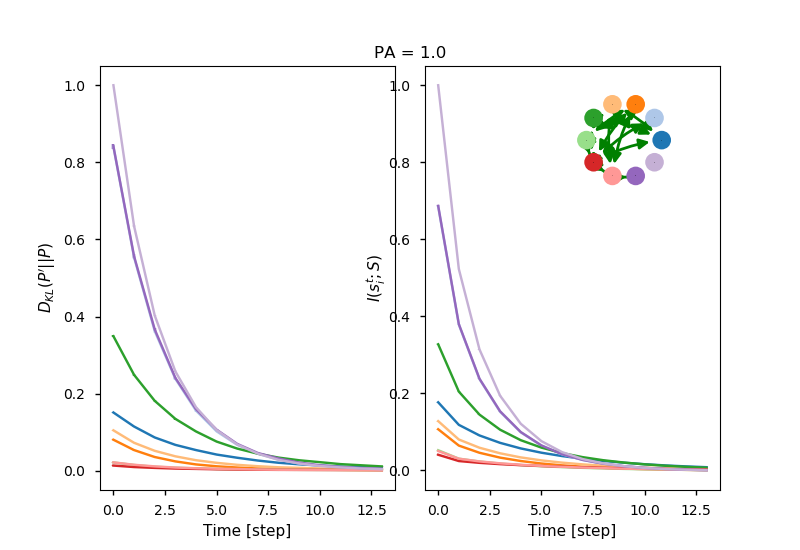

interactive(children=(SelectionSlider(description='dataidx', options=('../Data/new38/2019-09-05T12:31:44.64475…

In [52]:
nData, nPulses, nTemp = d.shape
print(d.shape)

e = d.argmax(1)
d = yy[:, 1:]
# print(yy)
e = yy[:, 1:].argmax(1)
print(e.shape)



import ipywidgets as widgets
from Utils.plotting import addGraphPretty
import networkx as nx
from scipy.stats import sem


dataSlider = widgets.SelectionSlider(\
                                    options = list(aucs.keys()),\
                                    value = list(aucs.keys())[0],\
                                    )


pulse = ['mi', *setting.pulseSizes]
pulseSlider = widgets.SelectionSlider(\
                                     options = pulse,\
                                     value = 'mi')

temperatureSlider = widgets.IntSlider(\
                                          min = 0,
                                          max = 2,\
                                          value = 0)

%matplotlib notebook
fig, ax = plt.subplots(1, 2)
@widgets.interact(dataidx = dataSlider,\
                 temperatureidx = temperatureSlider,\
                 )
def update(dataidx, temperatureidx):
    
#     pulseidx = [idx for idx, i in enumerate(pulse) if i == pulseidx][0]
    print('Data = ', dataidx)
    
    i = [idx for idx, i in enumerate(aucs.keys()) if i == dataidx][0]
    pulseidx = e[i, temperatureidx]
#     pulseidx = e
#     temperatureidx = {0.8: 0, 0.7:1, 0.6: 2}.get(pulseidx)
    data = settings[dataidx].data.mean(2)
    sigs = sem(settings[dataidx].data, axis = 2)
    
    
    data = data[pulseidx + 1, temperatureidx]
    sigs = sigs[pulseidx + 1, temperatureidx]
    
    xr = np.arange(data.shape[-1])
    colors = plt.cm.tab20(range(data.shape[0]))
    [axi.cla() for axi in ax]   
    axi, tax = ax
#     print(data.shape, sigs.shape, colors, xr)
    for idx, (x, y) in enumerate(zip(data, sigs)):
        axi.errorbar(xr, x, yerr = y, color = colors[idx])
        tax.errorbar(xr, settings[dataidx].data.mean(2)[0, temperatureidx, idx], \
                    yerr = sem(settings[dataidx].data, axis = 2)[0, temperatureidx, idx], color = colors[idx])
    xl = 'Time [step]'
    yl = "$D_{KL}(P' | | P )$"
    axi.set(xlabel = xl, ylabel = yl)
    tax.set(xlabel = xl
           )
    tax.set_ylabel('$I(s_i^t ; S)$', labelpad = -.05)
    y = d[i, pulseidx, temperatureidx]
    
    mainax = fig.add_subplot(111, frameon = 0, xticks = [], yticks = [])
    
    mainax.set_title(f'PA = {y}')
    
    inax = tax.inset_axes((.5, .65, .35, .35))
    addGraphPretty(nx.node_link_graph(settings[dataidx].graph), ax = inax)
    inax.axis('off')
    fig.subplots_adjust(wspace = .1)
    fig.canvas.flush_events()

In [ ]:
2019-08-22T15:43:34.412663

# Widget for time-data scrolling

In [ ]:
for k, v in settings.items():
    print(v.__dict__)

In [ ]:
import ipywidgets as widgets

from Utils.plotting import addGraphPretty
import networkx as nx
from scipy.stats import sem


dataSlider = widgets.SelectionSlider(\
                                    options = list(aucs.keys()),\
                                    value = list(aucs.keys())[0],\
                                    )


pulse = ['mi', *setting.pulseSizes]
pulseSlider = widgets.SelectionSlider(\
                                     options = pulse,\
                                     value = 'mi')

temperatureSlider = widgets.IntSlider(\
                                          min = 0,
                                          max = 2,\
                                          value = 0)

%matplotlib notebook
fig, ax = plt.subplots()
@widgets.interact(dataidx = dataSlider,\
                 pulseidx = pulseSlider,\
                 temperatureidx = temperatureSlider,\
                 )
def update(dataidx, pulseidx, temperatureidx):
    
    pulseidx = [idx for idx, i in enumerate(pulse) if i == pulseidx][0]
    print(pulseidx)
#     temperatureidx = {0.8: 0, 0.7:1, 0.6: 2}.get(pulseidx)
    data = settings[dataidx].data.mean(2)
    print(dataidx)
    sigs = sem(settings[dataidx].data, axis = 2)
    
    
    data = data[pulseidx, temperatureidx]
    sigs = sigs[pulseidx, temperatureidx]
    
    xr = np.arange(data.shape[-1])
    colors = plt.cm.tab20(range(data.shape[0]))
    ax.cla()
    
    print(data.shape, sigs.shape, colors, xr)
    for idx, (x, y) in enumerate(zip(data, sigs)):
        ax.errorbar(xr, x, yerr = y, color = colors[idx])
        
    xl = 'Time [step]'
    yl = '$I(s_i^t ; S)$' if pulseidx == 0 else "$D_{KL}(P' | | P )$"
    ax.set(xlabel = xl, ylabel = yl)
    
    inax = ax.inset_axes((.5, .65, .35, .35))
    addGraphPretty(nx.node_link_graph(settings[dataidx].graph), annotate = dict(fontsize = 100), ax = inax)
    inax.axis('off')
    fig.canvas.flush_events()
    
print(setting.pulseSizes)

In [ ]:

dataSlider = widgets.SelectionSlider(\
                                    options = list(aucs.keys()),\
                                    value = list(aucs.keys())[0],\
                                    )


pulse = [*setting.pulseSizes]
pulseSlider = widgets.SelectionSlider(\
                                     options = pulse,\
                                     value = pulse[0])

temperatureSlider = widgets.IntSlider(\
                                          min = 0,
                                          max = 2,\
                                          value = 0)

fig, ax = plt.subplots()
@widgets.interact(dataidx = dataSlider,\
                 pulseidx = pulseSlider,\
                 temperatureidx = temperatureSlider,\
                 )
def update(dataidx, pulseidx, temperatureidx):
    
    pulseidx = [idx + 1 for idx, i in enumerate(pulse) if i == pulseidx][0]
    print(pulseidx)
    data = aucs[dataidx]
    data = data[[0, pulseidx], temperatureidx]
    colors = plt.cm.tab20(range(data.shape[-1]))
    ax.cla()
    for idx, x in enumerate(data.T):
#         print(x.shape)
        ax.scatter(*x.T, color = colors[idx])
        
#         ax.errorbar(xr, x, yerr = y, color = colors[idx])
    xl = 'Informational impact'
    yl = 'Causal impact'
    ax.set(xlabel = xl, ylabel = yl)
    
    inax = ax.inset_axes((.5, .15, .35, .35))
    addGraphPretty(nx.node_link_graph(settings[dataidx].graph), ax = inax)
    inax.axis('off')
    fig.canvas.flush_events()

In [ ]:
tmp     = np.asarray([i for i in aucs.values()])
tmp     = np.argsort(tmp, axis = -1)
tmp     = tmp[..., -1]

print(tmp[0, 0])
d = []
for i in range(9):
    d.append(tmp[:, i + 1] == tmp[:, 0])
d = np.asarray(d)
print(d.mean(-1)[...,0].shape)
x = d.mean(-1)[...,:].max(0)


e = d.mean(-1)

fig, ax = plt.subplots(1, 3, figsize = (10, 5))

t = '0.8 0.7 0.6'.split()
for i in range(3):
    tax = ax[i]
    tax.imshow(e[..., i].T, extent = [.5, 5, 0, 20], aspect = 'auto', vmin = 0, vmax = 1)
    tax.set_title(f'Frac of mag {t[i]}')
#     tax.axis('equal')
mainax = fig.add_subplot(111, frameon = 0, xticks = [], yticks = [])
mainax.set_xlabel('Intervention size', labelpad = 20)
mainax.set_ylabel('Data idx', labelpad = 20)
mainax.set_title('Erdo renyi\n\n',)
fig.show()
# fig, ax = plt.subplots()
# ax.imshow(x)
# fig.show()

In [ ]:
zdx = 1
taucs = np.asarray([i for i in aucs.values()])
tmp = taucs[zdx]
tmp = np.argsort(tmp, axis = -1)[..., -1]

print(tmp.shape)
driverdata = determineDrivers(tmp[0, 0])
drivers = [i[0] for i in driverdata[1]]


tdata = np.asarray([i.data for i in settings.values()])[zdx]
mi = tdata[0, 0].mean(0)
print(driverdata)
colors = plt.cm.tab20(range(10))
fig, ax = plt.subplots()
for i in range(10):
    ax.plot(mi[i], color = colors[i], label = i)
ax.legend()
ax.set_title(drivers)
fig.show()

In [ ]:
a = np.random.rand(10)
print(np.sort(a), a[np.argsort(a)])

In [ ]:
# x = np.arange(s[-1])
# print(setting.mapping)

# pad = np.linspace(x.max() * 10, x.max() * 15, 10)
# x   = np.concatenate((x, pad))
# d = tmp.reshape(*s[:-1], -1)
# c = coeffs.reshape(*s[:-1], coeffs.shape[-1])
g = nx.node_link_graph(setting.graph)
fig, ax = plt.subplots()
addGraphPretty(g, ax = ax, positions = nx.spring_layout)
fig.show()

# IO.savePickle('../try_again', gr)
# xx = np.linspace(0, 200, 1000)

# fig, ax = plt.subplots()

# zdx = 4
# print(c.shape, d.shape, x.shape)
# for i in range(20):
#     idx = 0
#     ax.plot(x, d[zdx, i, idx], '.', color = 'red')
#     ax.plot(xx, func(xx, *c[zdx, i, idx]), alpha = .2, color = 'blue')

#     a = scipy.integrate.quad(lambda x: func(x, *c[zdx, i, idx]), 0, np.inf)[0]
#     print(idx, a)
# fig.show()
# a = np.array(list(aucs.values())).squeeze()
# print(a[13].mean(1))

In [ ]:
# load for optimal sets

import networkx as nx
optimals = np.zeros((len(aucs), 9))

for idx, (k, v) in enumerate(aucs.items()):
    v = v[:, 0]
#     print(v.shape)
#     assert 0
    v = v.squeeze()
    
    tmp = v.argmax(-1)
    
#     print(v.shape, v.argmax(-1))
#     print(idx, set(tmp[0]))
#     print(idx, v[0, 0])
    
#     print(idx, optimals[idx], tmp)
#     print((tmp[0] == tmp[1:]).shape)
#     assert 0
    for kdx, j in enumerate(tmp[1:]):
        optimals[idx, kdx] = (tmp[0] == j).mean()
#     optimals[idx] = (tmp[0, :] == tmp[1:, :]).mean(-1)
    if idx == 13 :
        print(tmp, v.mean(1))
    g = nx.node_link_graph(settings[k].graph)
    deg = dict(nx.degree(g))
#     print(deg)
#     print(idx, np.mean(list(deg.values())))
# print(optimals.shape, len(setting.pulseSizes))
fig, ax = plt.subplots()
h = ax.imshow(optimals, aspect = 'auto')
ax.set(ylabel = 'Graph index', xlabel = 'Nudge size', xticks = np.arange(0,9), \
      xticklabels = setting.pulseSizes)
fig.colorbar(h, label = 'Prediction accuracy')
fig.savefig('showrick')
fig.show()

print(optimals.max(1).mean())

In [ ]:
from Utils.plotting import addGraphPretty
graphs = [nx.node_link_graph(setting.graph) for setting in settings.values()]
g = graphs[5]

# fig, ax = plt.subplots()
# addGraphPretty(g, ax = ax, colors = colors)
# ax.legend()
# fig.show()


print(len(aucs), len(settings))

# fig, ax = plt.subplots()
# adj = nx.adj_matrix(g).todense()
# ax.imshow(adj)
# fig.show()


nodes = [0, 3, 8, 9]
nodesj = [4, 5, 7]
# for i in nodes:
#     for j in nodesj:
#         g2 = g.copy()
#         tmp = {node : node for node in g2.nodes()}
#         tmp[i] = j
#         tmp[j] = i
#         print(nx.is_isomorphic(g, g2))

# for node in g.nodes():
#     print(node, g.degree(node))
    

# print(nx.is_isomorphic(g,g))
d = list(settings.values())[-1].data
d = np.asarray(d).squeeze()
d = d.mean(1)
print(d.shape)
fig, ax = plt.subplots()
[ax.plot(i) for i in d[0]]

In [ ]:
for i in settings.keys():
    print(i)

In [ ]:
from functools import partial
import networkx as nx
centralities = dict(\
                   degree = nx.degree_centrality,
                   closeness = nx.closeness_centrality,\
                   eigen = nx.betweenness_centrality,\
                   betweeness = partial(nx.eigenvector_centrality, max_iter = 1000),\
                   )

predictors = np.zeros((len(settings), 9, 4))


for kdx, (k, v) in enumerate(settings.items()):
    if k in aucs:
        tmp = aucs[k][1:].squeeze()

        pred = tmp.argmax(-1)
        g = nx.node_link_graph(v.graph)

        for idx, (c, cf) in enumerate(centralities.items()):
            ce = cf(g)
            xx = np.asarray(list(ce.values()))
            node  = xx.argmax()
            correct = (pred == node).mean(1)
            predictors[kdx, :, idx] = correct

    
%matplotlib notebook

from mpl_toolkits.axes_grid1 import AxesGrid
from matplotlib import style; style.use('seaborn-notebook')



gs = dict(height_ratios = [1, 1,  .7], width_ratios = [1, 1, 1, 1, 1])
fig, axes = plt.subplots(3, 5, figsize = (12,8), sharey = 'row', sharex = 'row', gridspec_kw = gs)        


m, n = np.min(setting.pulseSizes), np.max(setting.pulseSizes)
mm, nn = predictors.shape[0], 0
extent = [m, n, mm, nn]
ax = axes[0,0]
ax.imshow(optimals, aspect = 'auto', vmin = 0, vmax = 1, extent = extent)
ax.set_ylabel('Graph index')
ax.set_title("Informational\nimpact")

centLabels = list(centralities.keys())
for idx, tmp in enumerate(predictors.T):
    ax = axes.ravel()[idx + 1]
    ax.axis('equal')
    h = ax.imshow(tmp.T, aspect = 'auto', vmin = 0, vmax = 1, extent = extent)
    ax.set_title(centLabels[idx])
#     ax.set(xticklabels = setting.pulseSizes, xticks = range(9))

fig.colorbar(h, ax = ax, label = 'Prediction accuracy')
mainax = fig.add_subplot(311, xticks = [], yticks = [], frameon = 0)
from mpl_toolkits.axes_grid1 import make_axes_locatable

# cbar_ax = fig.add_axes([0.85, 0.35, 0.05, .75])
# divider = make_axes_locatable(mainax)
# cax = divider.append_axes( right", size="5%", pad=0.05)
# cbaxes = fig.add_axes([.9, 0.1, 0.03, 0.82]) 
# cb = fig.colorbar(h, cax = cbaxes)  

# fig.colorbar(h, cax = cbar_ax, label = 'Prediction accuracy')
fig.subplots_adjust(wspace = .05, hspace = .28)
mainax.set_xlabel('Nudge size', labelpad = 35)

mainax = fig.add_subplot(312, xticks = [], yticks = [], frameon  = 0)
mainax.set_xlabel('Informational impact', labelpad = 50)
axes[1, 1].set_ylabel('Causal impact', labelpad = 12)

# add example area curves
"""
The idea would be to maybe use:
1 - optimized example

2 - unoptimized example
3 - never working example
4 - never working example (not used)
"""


tmp = np.array(list(aucs.values()))
print(tmp.shape)
tmp = tmp[:, 0]
def rescale(x):
    s = x.shape
    tmp = x.reshape(s[0], -1)
    MIN, MAX = tmp.min(1), tmp.max(1)
    tmp = (tmp - MIN[:, None]) / (MAX[:, None] - MIN[:, None])
    return tmp.reshape(s)


axes[1, 0].axis('off')
# 1

idx = 0
d = tmp[idx, [0, optimals[idx].argmax() + 1]]
d = rescale(d)
for node in range(10):
    axes[1, 1].scatter(*d[..., node], color = colors[node])

 
graphs = [nx.node_link_graph(v.graph) for k, v in settings.items()]
# inax.axis('off')
addGraphPretty(graphs[idx], axes[2,1], colors = colors)
axes[2,1].axis('off')
# axes[1, 1].set_title(f'Nudge = {setting.pulseSizes[optimals[0].argmax()]}')
axes[1,1].set_title('Optimized nudge')


# 2
d = tmp[idx, [0,  optimals[idx].argmin() + 1]].squeeze()
d = rescale(d)
for node in range(10):
    axes[1,2].scatter(*d[..., node], color = colors[node])
# axes[1, 2].set_title(f'Nudge = {setting.pulseSizes[-1]}')
axes[1,2].set_title('Unoptimized')

# 3 
# idx = 23
idx = 8
d = tmp[idx, [0, optimals[idx].argmax() + 1]].squeeze()
d = rescale(d)
for node in range(10):
    axes[1,3].scatter(*d[..., node], color = colors[node])
# axes[1, 3].set_title(f'Nudge = {setting.pulseSizes[-1]}')
axes[1,3].set_title('No resolution')

addGraphPretty(graphs[idx], axes[2,3], colors = colors)
axes[2,3].axis('off')


for i in range(5):
    axes[2, i].axis('off')
    
# 4
# idx = 15
axes[1, 4].axis('off')

fig.subplots_adjust(hspace = .55)
# d = tmp[idx, [0, 0]].squeeze()
# d = rescale(d)
# for node in range(10):
#     axes[1,3].scatter(*d[..., node], color = colors[node])
# axes[1, 3].set_title(f'Nudge = {setting.pulseSizes[-1]}')

# mainax.set_ylabel('Graph index', labelpad = 30)
# fig.savefig('summary_results_all.eps'


In [ ]:
# from scipy.stats import gaussian_kde as gkde, zscore
# from seaborn import kdeplot
# x = np.linspace(0, 2, 1000)
# idx = 5
# fig, ax = plt.subplots()


# xx = np.array(setting.pulseSizes)
# yy = optimals[idx]

# xx = (xx - xx.min()) / (xx.max() - xx.min())
# yy = (yy - yy.min()) / (yy.max() - yy.min())

# y = gkde(yy)
# ax.scatter(x, y(x))
# ax.scatter(xx, yy)
# fig.show()
import datetime
g = []

s = {k : v for idx, (k, v) in enumerate(settings.items()) if idx in [0, len(settings) -1]}

for k, v in s.items():
    gi = nx.node_link_graph(v.graph)
    start = v.directory.split('/')[-1]
    gi.start = datetime.datetime.fromisoformat(start)
    g.append(gi)
    
IO.savePickle('../rerunthese2.pickle', dict(graphs = g))
print(len(g))
# print(start)
# datetime.datetime.fromisoformat(start)
# fig, ax = plt.subplots()
# addGraphPretty(g[0], ax = ax)
# fig.show()

In [ ]:
fig, axes = plt.subplots(2, 2)


tcolors = plt.cm.viridis(np.linspace(0, 1, 29))
for kdx, (k, v) in enumerate(aucs.items()):
    jdx  = optimals[kdx].argmax()
    v = v.squeeze()
    nodes =  set(v[jdx].argmax(-1))
    mi = v[0]
    g = nx.node_link_graph(settings[k].graph)
    
    for idx, (c, cf) in enumerate(\
                                  centralities.items()):
        
        ce = np.array(list(dict(cf(g)).values()))
        ax = axes.ravel()[idx]
        
        for node in range(10):
            ax.scatter(mi[:, node].mean(), ce[node], color = tcolors[kdx])
#         for node in nodes:
#             ax.scatter(mi[:, node].mean(), ce[node], color = 'blue')
fig.show()
            
        
        
    
    

In [ ]:
tmp = np.array([i for i in aucs.values()])
print(tmp.shape)

d = np.zeros((tmp.shape[0], 2, 20))
for idx, i in enumerate(optimals):
    jdx = np.argmax(i)
    d[idx] = np.argmax(tmp[idx, [0, jdx + 1]].squeeze(), axis = -1)

    
pxs = []
temps = np.zeros(len(data))
for idx, ds in enumerate(data):
    tf = os.path.join(ds, '0.8', 'control')
    h = os.path.join(ds, 'mags.pickle')
    te= IO.loadPickle(h)['matchedTemps']
    temps[idx] = te
    files = os.listdir(tf)
    
    tmp = []
    for f in files:
        tmp.append(IO.loadPickle(os.path.join(tf, f)).px)
    
    pxs.append(tmp)
pxs = np.array(pxs)
# what are the properties of the driver-nodes
# look at average energies


In [ ]:
px = pxs.mean(-3)
# print(px.shape, temps.shape)

energies = []

en = lambda x, beta: - np.log(1 / x - 1) / beta

c = plt.cm.tab20(range(12))
for idx, i in enumerate(d):
    # go through trials
    # get max driver-node
    alphas = np.linspace(0.2, 1, len(set(i[0])))
    alphas = {i: j  for i, j in zip(set(i[0]), alphas)}
    for jdx, j in enumerate( i[0]) :
        tmp = px[idx, jdx, int(j)][0]
        dc = c[idx]
        dc[-1] = alphas[j]
        energies.append( (tmp, en(tmp, temps[idx]), dc) )
    
energies = np.array(energies)
fig, ax = plt.subplots()
ax.scatter(energies[:, 1], energies[:,0], color = energies[:, -1])

ax.set(xlabel = 'Energy', ylabel = 'P',\
      title = 'Energy of driver-nodes')
fig.show()
print(optimals.max(1))

In [ ]:
for idx, g in enumerate(graphs):
    deg = np.array([ i for i in dict(g.degree()).values()])
    
    pidx = optimals[idx].argmax()
    p = setting.pulseSizes[pidx]
    print(p, deg.mean(), deg.max(), deg.min(), np.median(deg))

In [ ]:
h

In [ ]:

for kdx, (k, v) in enumerate(aucs.items()):
    v = v.squeeze()
    if kdx >= 0:
        fig, ax = plt.subplots()
    #     idx = 1
        idx = [i for i, j in enumerate(optimals[kdx]) if j == optimals[kdx].max()][0] 
        frac = optimals[kdx, idx]
        nudge = settings[k].pulseSizes[idx]
        for node in range(10):
            ax.scatter(*v[[0, idx + 1], 0, ..., node], label = node, color = colors[node])
        ax.set_title(f'idx={kdx} Nudge={nudge} Fraction correct={frac}')
#         ax.legend()
        inax = ax.inset_axes(bounds = (.1, .7, .4, .4))
        inax.axis('off')
        g = nx.node_link_graph(settings[k].graph)
        addGraphPretty(g, inax, positions = nx.spring_layout)
#         inax.imshow(nx.adjacency_matrix(g).todense())
        ax.set(xlabel = 'Informational impact', ylabel = 'Causal impact')
        fig.show()

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
%matplotlib notebook


ALL = np.zeros((6, len(aucs)))

cMetrics = np.zeros((len(aucs), len(centralities)))
for kdx, (k, v) in enumerate(aucs.items()):
    tmp = v.squeeze().mean(1)
    idx = [i for i, j in enumerate(optimals[kdx, :]) if j == optimals[kdx].max()][0]
    
#     print(settings[k].rmapping)
    
    node = tmp[idx].argmax()
#     node = settings[k].rmapping[str(idx)]
    
    g = settings[k].graph
    g = nx.node_link_graph(g)
#     print(node, g.nodes())
    node2 = tmp[0].argmax()
    
    ALL[:2, kdx] = node2, node
    for jdx, (c, cf) in enumerate(centralities.items()):
        ce = cf(g)
        xx = abs(np.array([i for i in dict(ce).values()]))
        ALL[jdx + 2, kdx] = xx.argmax()
        cMetrics[kdx, jdx] = xx.max()
        
        

from  scipy.stats import zscore

tmp = [i for i in range(ALL.shape[0]) if i != 1]

d = np.zeros((len(tmp)))

for idx, i in enumerate(tmp):
    d[idx] = (ALL[i] == ALL[1]).mean()
    
x = np.arange(d.size)
fig, ax = plt.subplots()
ax.bar(x, d)
s = '\t'.join(i for i in centralities.keys())
print(s)
ax.set(xticklabels = f'Informational\nimpact\t{s}'.split('\t'), xticks = x, \
      ylabel = 'predicton accuracy')
ax.set(title = 'Optimal nudge driver-node prediction')
fig.show()

In [ ]:
from matplotlib import style
style.use('seaborn-notebook')
%matplotlib notebook

x = np.linspace(0, 50)
fig, ax = plt.subplots()

test = np.zeros((coeffs.shape[0], 10))

print(coeffs.shape, test.shape)
for i in range(10):
    for j in range(coeffs.shape[0]):
        ax.plot(x, func(x, *coeffs[j, i]), color = colors[i], alpha = .2)
        test[j, i] = scipy.integrate.quad(lambda x: func(x, *coeffs[j, i]), 0, np.inf)[0]
        ax.plot(mi[j, i], color = colors[i], linestyle = 'none', marker = '.',)
h = [plt.Line2D([0], [0], marker = '.', linestyle = 'none',\
                color = colors[i], label = i) for i in range(10)\
    ]
ax.legend(handles = h) 
fig, ax = plt.subplots()
ax.imshow(test)
fig.show()

In [ ]:
fig, ax = plt.subplots()

settingName = next(iter(loadedData))
setting = settings[settingName]
graph = nx.node_link_graph(setting.graph)
import networkx as nx
from Utils.plotting import addGraphPretty
addGraphPretty(ax = ax, graph = graph)
fig.show()

# Notes on the data

Rick mentioned that it could be the case that although the data does not look linear, it is because each graph has some slightly odd behavior in regards of how the entropy decays. Meaning, it could be that across graphs the lines are not necessarily on a line. However, the prediction accuracy should still be high.

Things to check:
    - Check the ordering over time of the curves for different datasets
    - Check the prediction accuracy
    

In [ ]:
from bokeh import plotting as bp
from bokeh.models import ColumnDataSource, CustomJS
import bokeh
bp.output_notebook()


tmp_aucs = [i.squeeze() for i in aucs.values()]
x = []

sets = [0, 2]

for i in tmp_aucs:
    idx = i[sets[1]].argmax()
#     tmp = i[sets].max(-1)
    tmp  = i[sets, idx]
#     print(i.shape)
    x.append(tmp)

tmp_aucs = np.asarray(x)
# print(tmp_aucs.shape, idx.shape); assert 0

tmp_mi   = [loadedData[i].squeeze() for i in aucs.keys()]
tmp_mi   = tmp_mi

viridis = bokeh.palettes.Viridis256
# setup data
buffer          = ColumnDataSource('x', 'y', \
                                   data = dict(x = [], \
                                               y = [], \
                                               color = [])\
                                  )

buffer_causal   = ColumnDataSource('x', 'y', \
                                   data = dict(x = [], \
                                               y = [],\
                                              color = []),\
                                  )

aucs_bokeh = ColumnDataSource('x', 'y', data = dict(x = tmp_aucs[:,0].tolist(), \
                                                    y = tmp_aucs[:, 1].tolist(), \
                                                    ),\
                              )

mi_bokeh    = ColumnDataSource(data = dict(y = [i[0].tolist() for i in tmp_mi]))
causal_bokeh= ColumnDataSource(data = dict(y = [i[sets[-1]].tolist() for i in tmp_mi]))

f1 = bp.figure(tools = 'hover tap lasso_select'.split(), width = 600)
f2 = bp.figure( height = int(f1.plot_height * .5 ))
f3 = bp.figure( height = int(f1.plot_height * .5 ))

for prop, label in zip('yaxis xaxis'.split(), ['Mutual information', 'time']):
    getattr(f2, prop).axis_label = label

for prop, label in zip('yaxis xaxis'.split(), ['Causal impact', 'time']):
    getattr(f3, prop).axis_label = label
f1.scatter('x', 'y', source = aucs_bokeh, size = 10)

# fi1.scatter()
f2.multi_line('x', 'y', source = buffer, color = 'color')
f3.multi_line(xs = 'x', ys = 'y', source = buffer_causal, color = 'color')

with open('dashboard.js', 'r') as f:
    callback = ''.join(i for i in f.readlines())
    
    JS =  CustomJS(\
             args = dict(buffer = buffer, \
                         mi     = mi_bokeh, \
                         buffer_causal = buffer_causal, \
                         causal = causal_bokeh, 
                         colors = bokeh.palettes.Magma256,\
              ),\
             code = callback)
aucs_bokeh.selected.js_on_change('indices', \
                                JS)
bp.show(bokeh.layouts.row(f1, bokeh.layouts.column(f2, f3)))


# AUC for all data

showing the data for not only the driver-node

In [ ]:
# aucs = {}
# for k, v in loadedData.items():
#     v = v.squeeze()
#     s = v.shape
#     v = v.reshape(v.shape[0], -1)
#     mi, ma = v.min(1), v.max(1)
#     print(v.shape)
#     mi = mi[:, None]
#     ma = ma[:, None]
# 
#     v = (v - mi) / (ma - mi)
#     print(v.max(1))
#     v = v.reshape(s)
#     aucs[k] = np.trapz(v, axis = -1)
for k, v in loadedData.items(): print(v.shape)
predictions = np.zeros((len(loadedData), 2))

for idx, (k, v) in enumerate(aucs.items()):
    jdx = v.squeeze().argmax(-1)
    tmp = v.squeeze().argsort(-1)
    jdx = tmp[:, -1]
#     print(np.argsort(v.squeeze(), axis = -1)[:, -3:])
    tmp = jdx[0] == jdx[1:]
#     print(jdx, v.shape)
    predictions[idx] = tmp

fig = bp.figure()
colors = bokeh.palettes.Viridis256

N = len(colors) // len(aucs)
for idx,(k, v) in enumerate(aucs.items()):
    fig.scatter(*v.squeeze()[[0,2]], color = colors[idx * N])
#     print(v.squeeze()[[0,1]])
fig.xaxis.axis_label = 'Informational impact'
fig.yaxis.axis_label = 'Causal impact'
print(predictions.mean(0))
bp.show(fig)

In [ ]:
func = lambda x, a, b, c, d, e, f: a + b * np.exp(- c * x) + d * np.exp(- e * (x - f))
x = np.linspace(0, 20)
def idt(data, func, perc = .5, params = {}):
    """
    Compute idt for data set (node x time)
    """
    from Utils.plotting import fit
    coeffs, error = fit(data, func, params = params)
    idts = np.zeros((data.shape[0]))
    for idx, c in enumerate(coeffs):
        tmp = lambda x : abs(func(x, *c) - data[idx].max() * perc)
        idts[idx] = scipy.optimize.fmin(tmp, np.random.rand(), disp = 0)[0]
    return idts, coeffs
%matplotlib notebook
from matplotlib import style
style.use('seaborn-notebook')
params = dict(\
             maxfev = int(1e4),\
             bounds = (0, np.inf),\
             )
mi = next(iter(loadedData.values())).squeeze()
auc = next(iter(aucs.values())).squeeze()
print(mi.shape)
zdx = 2 
idts, coeffs = idt(mi[zdx], func, .5, params)

fig, ax = plt.subplots()

colors = plt.cm.tab20(range(12))
for idx, vi in enumerate(mi[zdx]):
    ax.plot(vi, color = colors[idx], linestyle = 'none', marker=  '.', markersize = 10,\
           label = setting.rmapping[str(idx)])
    ax.axvline(idts[idx], color = colors[idx], alpha = .7, linestyle = ':', markersize = 1600)
    ax.plot(x, func(x, *coeffs[idx]), color = colors[idx], linestyle = 'dashed')
    
#     if idx == auc[zdx].argmax():
#         ax.add_artist(plt.Circle((20, 1) , color = colors[idx]))
ax.set(\
      xlabel = 'Time',\
      ylabel = 'KL-divergence' if zdx != 0 else 'Mutual information',\
      ) 

ax.legend()
fig.show()

In [ ]:
mu = mi.mean(1)
# var = mi.std(1)

from scipy.stats import sem
var = sem(mi, axis = 1)
print(var)
setting = next(iter(settings.values()))
print(setting.mapping)
print(mu.shape)

theta = 4
times = np.zeros((3), dtype = int)

fig, ax = plt.subplots()
for idx, i in enumerate(mi):
    for jdx, j in enumerate(i.T):
        dd = np.argsort(j)
        second, first = dd[-2:]
        ax.scatter(jdx,  (j[first] - j[second])**2, color = colors[idx])
        if jdx > 0:
            print(idx, j[first], mu[idx, jdx] + theta * var[idx, jdx])
            
            if j[first] > mu[idx, jdx] + theta * var[idx, jdx]:
                times[idx] = jdx
            else:
                break
            
print(times)
print(setting.rmapping)
for idx, i in enumerate(times):
    node = mi[idx, :, i].argmax()
    print(idx, setting.rmapping[str(node)])
print(times)

In [ ]:
# fig, ax = plt.subplots()
# colors = plt.cm.Spectral(np.linspace(0, 1, len(tmp_aucs)))
# [ax.scatter(*i[:2], color = colors[idx]) for idx, i in enumerate(tmp_aucs)]
# fig.show()

idx = []
for k, v in aucs.items():
    # get max
    tmp = np.argsort(v.squeeze(), axis = -1)
    if tmp[0, -1] != tmp[1, -1]:
        idx.append(k)


In [ ]:
tmp = idx[0]
setting = settings[tmp]
print(aucs[tmp].argsort(-1))
print(len(idx))
def idt(data, perc = .5, params = {}):
    """
    Compute idt for data set (node x time)
    """
    from Utils.plotting import fit
    
    func = lambda x, a, b, c, d, e, f: a + b * np.exp(- c * x) + d * np.exp(- e * (x - f))
    coeffs, error = fit(data, func, params = params)
    idts = np.zeros((data.shape[0]))
    for idx, c in enumerate(coeffs):
        tmp = lambda x : abs(func(x, *c) - data[idx].max() * perc)
        idts[idx] = scipy.optimize.fmin(tmp, np.random.rand(), \
                                       disp = 0)[0]
    return idts


print(settings[tmp])
        
import matplotlib.pyplot as plt
d = loadedData[tmp].squeeze()


idts = idt(d[1], params = dict(bounds = (0, np.inf), maxfev = int(1e4)))
idts2= idt(d[0], params = dict(bounds = (0, np.inf), maxfev = int(1e4)))
print(d.shape)


colors = plt.cm.tab20(range(d.shape[1]))
fig, (ax, tax, ttax) = plt.subplots(1, 3)
for node in range(d.shape[1]):
    ax.plot(d[0, node], color = colors[node])
    ax.axvline(idts2[node], color = colors[node])
    tax.plot(d[1, node], color = colors[node], linestyle = 'dashed')
    ttax.plot(d[2, node], color = colors[node])
    tax.axvline(idts[[node]], color = colors[node])
tax.set(ylabel = 'causal')
tax.yaxis.labelpad = 0
ax.set(ylabel = 'informational')

# elements = [plt.Line2D([0], [0], linestyle = i, color = 'k', label = j) for i, j in zip(\
#                    'dashed solid'.split(), 'causal informational'.split())]
# ax.legend(handles = elements)
mainax = fig.add_subplot(111, xticks = [] , yticks = [], frameon = False)
mainax.set_xlabel('time', labelpad = 20)

inax = tax.inset_axes([0.5, 0.5, 0.7, 0.7])
import networkx as nx
graph = nx.node_link_graph(settings[tmp].graph)
from Utils.plotting import addGraphPretty
addGraphPretty(graph, positions = nx.spring_layout, ax = inax, colors = colors)
inax.axis('off')
fig.subplots_adjust(wspace = .4)
print(np.argsort(aucs[tmp], axis = -1).squeeze())
print(settings[tmp])


from Utils import IO

IO.savePickle('../craph_graph3.pickle', nx.node_link_graph(setting.graph))